In [ ]:
!pip install opencv-python
!pip install scikeras

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import scipy

In [5]:
from keras import layers
from keras import models
from keras import utils
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Activation
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets
from keras.layers import InputLayer
from scipy.optimize import minimize

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

from keras import losses
from sklearn.utils import shuffle

In [ ]:
#https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

In [6]:
# fix random seed for reproducibility
np.random.seed(5)

In [12]:
#loading the data
mnist = tf.keras.datasets.mnist

#split into training data and testing data (usually 80-20)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

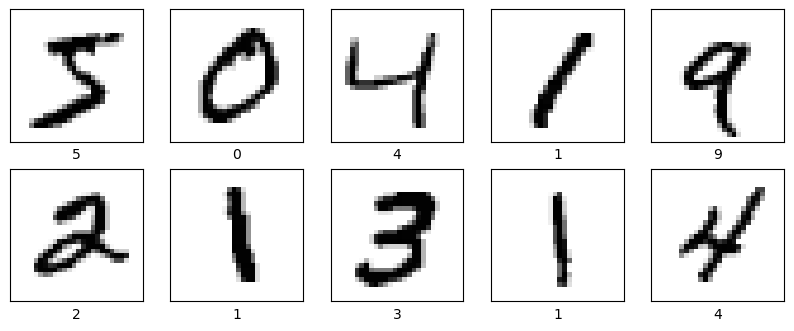

In [13]:
#Check the dataset
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])

In [14]:
#normalize training sets so instead of having colours go from 0-255 they now go 
#from 0-1 based on the length of the axis
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [ ]:
#Flatten the 2D images into 1D vectors
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

num_classes = 10

# Check the column length
x_train.shape[1]

In [16]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [17]:
#Stochastic Gradient Descent (SGD)
epochs=60
#Hyperparameters (typical values are learning_rate = 0.1, decay=1e-6, momentum=0.9, and nesterov=True
#learning_rate = 0.1
#decay_rate = learning_rate / epochs
#momentum = 0.8

sgd = SGD(learning_rate=0.1, momentum=0.8, nesterov=False)

In [ ]:
# build the model
input_dim = x_train.shape[1]

lr_model = Sequential()
lr_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) 
lr_model.add(Dropout(0.1))
lr_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
lr_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# compile the model
lr_model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['acc'])

In [ ]:
%%time
# Fit the model
batch_size = int(input_dim/100)

lr_model_history = lr_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(lr_model_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(lr_model_history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
#Stochastic Gradient Descent (SGD)
epochs=60
#Hyperparameters (typical values are learning_rate = 0.1, decay=1e-6, momentum=0.9, and nesterov=True
learning_rate = 0.1
decay_rate = learning_rate / epochs
#momentum = 0.8

sgd = SGD(learning_rate=0.1, momentum=0.8, nesterov=False)

In [ ]:
# build the model
input_dim = x_train.shape[1]
num_classes = 10
batch_size = 196

exponential_decay_model = Sequential()
exponential_decay_model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', input_dim = input_dim))
exponential_decay_model.add(Dropout(0.1))
exponential_decay_model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
exponential_decay_model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))


exponential_decay_model.compile(loss='categorical_crossentropy', 
                                optimizer=sgd, 
                                metrics=['acc'])

# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate

# learning schedule callback
loss_history = History()
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [loss_history, lr_rate]

# you invoke the LearningRateScheduler during the .fit() phase
exponential_decay_model_history = exponential_decay_model.fit(x_train, y_train,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    callbacks=callbacks_list,
                                    verbose=1,
                                    validation_data=(x_test, y_test))

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(exponential_decay_model_history.history['acc']), 'r', label='train')
ax.plot(np.sqrt(exponential_decay_model_history.history['val_acc']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
# build the model
input_dim = x_train.shape[1]

model = Sequential()
model.add(Dense(64, activation=tf.nn.relu, kernel_initializer='uniform', 
                input_dim = input_dim)) # fully-connected layer with 64 hidden units
model.add(Dropout(0.1))
model.add(Dense(64, kernel_initializer='uniform', activation=tf.nn.relu))
model.add(Dense(num_classes, kernel_initializer='uniform', activation=tf.nn.softmax))

# defining the parameters for RMSprop (I used the keras defaults here)
rms = RMSprop(learning_rate=0.001, rho=0.9, decay=0.0)

model.compile(loss='categorical_crossentropy',
              optimizer=rms,
              metrics=['acc'])

In [ ]:
%%time
batch_size = input_dim
epochs = 60

model_history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['acc']), 'r', label='train_acc')
ax.plot(np.sqrt(model_history.history['val_acc']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model_history.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model(init_mode='uniform'):
    # define model
    model = Sequential()
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu, input_dim=784)) 
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init_mode, activation=tf.nn.relu))
    model.add(Dense(10, kernel_initializer=init_mode, activation=tf.nn.softmax))
    # compile model
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    return model

In [ ]:
%%time
seed = 7
np.random.seed(seed)
batch_size = 128
epochs = 10

model_CV = KerasClassifier(model=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=1, init_mode='uniform')
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 
             'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']

param_grid = dict(init_mode=init_mode)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

In [ ]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

In [ ]:
# repeat some of the initial values here so we make sure they were not changed
input_dim = x_train.shape[1]
num_classes = 10

# let's create a function that creates the model (required for KerasClassifier) 
# while accepting the hyperparameters we want to tune 
# we also pass some default values such as optimizer='rmsprop'
def create_model_2(activation_function='relu',optimizer='rmsprop', init='uniform'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, kernel_initializer=init, activation=activation_function))
    model.add(Dropout(0.1))
    model.add(Dense(64, kernel_initializer=init, activation=activation_function))
    model.add(Dense(num_classes, kernel_initializer=init, activation=tf.nn.softmax))

    # compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])

    return model

In [ ]:
%%time
# fix random seed for reproducibility (this might work or might not work 
# depending on each library's implenentation)
seed = 7
np.random.seed(seed)

# create the sklearn model for the network
model_init_batch_epoch_CV = KerasClassifier(model=create_model_2, batch_size = 40, verbose=1, epochs = 10, init = "uniform")
model_init_batch_epoch_CV
# # we choose the initializers that came at the top in our previous cross-validation!!
init_mode = ['uniform', 'glorot_uniform', 'he_uniform'] 
batches = [128, 512]
epochs = [10, 20]
activation = ['relu', 'sigmoid']


# # grid search for initializer, batch size and number of epochs
param_grids = dict(epochs=epochs, batch_size=batches, init=init_mode)
grid = GridSearchCV(estimator=model_init_batch_epoch_CV, 
                    param_grid=param_grids,
                    cv=3)
grid_result = grid.fit(x_train, y_train)

In [ ]:
model_init_batch_epoch_CV.get_params().keys()

In [ ]:
# print results
print(f'Best Accuracy for {grid_result.best_score_:.4} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'mean={mean:.4}, std={stdev:.4} using {param}')

In [ ]:
#One last question before we end: what do we do if the number of parameters and values we have to cycle through in our GridSearchCV is particularly large?

#This can be a particularly troublesome problem — imagine a situation where there are five parameters being selected for and 10 potential values that we have selected for each parameter. The number of unique combinations of this is 10⁵, which means we would have to train a ridiculously large number of networks. It would be insanity to do it this way, so it is common to use RandomizedCV as an alternative.

#RandomizedCV allows us to specify all of our potential parameters. Then for each fold in the cross-validation, it selects a random subset of parameters to use for the current model. In the end, the user can select the optimal set of parameters and use these as an approximate solution.

In [ ]:
# build the model

#creatae layers and set activation
model = tf.keras.models.Sequential()

#add the first layer which flattens the later from 28x28 to a 784 layer
model.add(tf.keras.layers.Flatten(input_shape=(28,28)))

#Add second layer (dense), which is just a basic layer which is connected to all neurons
#First mention how many neuros
#Secondly mention the activation (relu = rectivy linear unit returns x if x > 0 and 0 if x<= 0) 
#different activation (relu, sigmoid, tanh, elus, etc.
model.add(tf.keras.layers.Dense(128, activation='sigmoid', kernel_initializer='he_uniform'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(128, activation='sigmoid', kernel_initializer='he_uniform'))

#Output layer, represents individual numbers 0-9
#Activation softmax = gives the highest probability of a specific individual number
model.add(tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='he_uniform'))

In [ ]:
# defining the parameters for RMSprop (I used the keras defaults here)
rms = RMSprop(learning_rate=0.001, rho=0.9)

model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer=rms)

In [ ]:
%%time

model_history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=60,
                    verbose=1,
                    validation_data=(x_test, y_test))

In [ ]:
model.save('trained_neural_network_2_0.keras')

In [ ]:
#load the model if you have it saved to skip training steps
model = tf.keras.models.load_model('trained_neural_network_2_0.keras')

In [ ]:
#initialize image number
image_number = 1

#while you have more images
while os.path.isfile(f"Hand written numbers/digit{image_number}.png"):
    try:
        #read the image
        img = cv2.imread(f"Hand written numbers/digit{image_number}.png")[:,:,0]
        #invert the colours (black to white and white to black) and make into an array
        img = np.invert(np.array([img]))
        #now predict the number of the image using the model
        prediction = model.predict(img)
        #print prediction np.argmax gives the field that has the highest number
        print(f"the number is probably a {np.argmax(prediction)}")
        plt.imshow(img[0], cmap=plt.cm.binary)
        plt.show()
    except:
        print("Error!")
    finally:
        image_number += 1

In [ ]:
model = tf.keras.models.load_model('model_01.keras')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model.history['acc']), 'r', label='train_acc')
ax.plot(np.sqrt(model.history['val_acc']), 'b' ,label='val_acc')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model.history['loss']), 'r', label='train')
ax.plot(np.sqrt(model.history['val_loss']), 'b' ,label='val')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)